In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [1]:

import pandas as pd

# Replace the filename with your actual file name if it's different
df = pd.read_csv("Bitcoin_Tweets.csv")

# Display the first 5 rows
df.head()



,token,date,reply_count,like_count,retweet_count,quote_count,text,sentiment_label,sentiment_score
0,bitcoin,00:00.0,20,207,31,3,Most people underestimate the impact #Bitcoin ...,Neutral,0.717482
1,bitcoin,00:00.0,232,3405,286,27,#Bitcoin has started a new yearly candle https...,Neutral,0.810814
2,bitcoin,00:00.0,2,861,12,0,@DESTROYBINARY did people forget that the amog...,Neutral,0.606978
3,bitcoin,00:00.0,18,306,30,9,"In 2017, miners attempted to assert control ov...",Negative,0.510956
4,bitcoin,00:00.0,35,721,35,1,Yearly Close \nMonthly Close\nDaily Close\n\nh...,Positive,0.988296


In [7]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 76734 entries, 0 to 76796
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   token            76734 non-null  object 
 1   date             76734 non-null  object 
 2   reply_count      76734 non-null  int64  
 3   like_count       76734 non-null  int64  
 4   retweet_count    76734 non-null  int64  
 5   quote_count      76734 non-null  int64  
 6   text             76734 non-null  object 
 7   sentiment_label  76734 non-null  object 
 8   sentiment_score  76734 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 5.9+ MB


token              0
date               0
reply_count        0
like_count         0
retweet_count      0
quote_count        0
text               0
sentiment_label    0
sentiment_score    0
dtype: int64

In [3]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [4]:
df.columns

Index(['token', 'date', 'reply_count', 'like_count', 'retweet_count',
       'quote_count', 'text', 'sentiment_label', 'sentiment_score'],
      dtype='object')

In [2]:
from textblob import TextBlob
TextBlob("Bitcoin is awesome!").sentiment

Sentiment(polarity=1.0, subjectivity=1.0)

In [6]:
import pandas as pd
from textblob import TextBlob

# Load your CSV file
df = pd.read_csv("Bitcoin_Tweets.csv")   # or your correct file name

# Your function definitions and analysis code come after loading the DataFrame
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df['sentiment_score'] = df['text'].apply(get_sentiment)

def categorize(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(categorize)
df.head()

,token,date,reply_count,like_count,retweet_count,quote_count,text,sentiment_label,sentiment_score,sentiment
0,bitcoin,00:00.0,20,207,31,3,Most people underestimate the impact #Bitcoin ...,Neutral,0.166667,Positive
1,bitcoin,00:00.0,232,3405,286,27,#Bitcoin has started a new yearly candle https...,Neutral,0.136364,Positive
2,bitcoin,00:00.0,2,861,12,0,@DESTROYBINARY did people forget that the amog...,Neutral,0.250000,Positive
3,bitcoin,00:00.0,18,306,30,9,"In 2017, miners attempted to assert control ov...",Negative,-0.200000,Negative
4,bitcoin,00:00.0,35,721,35,1,Yearly Close \nMonthly Close\nDaily Close\n\nh...,Positive,0.130579,Positive


In [10]:
df['sentiment_score'] = df['text'].apply(get_sentiment)

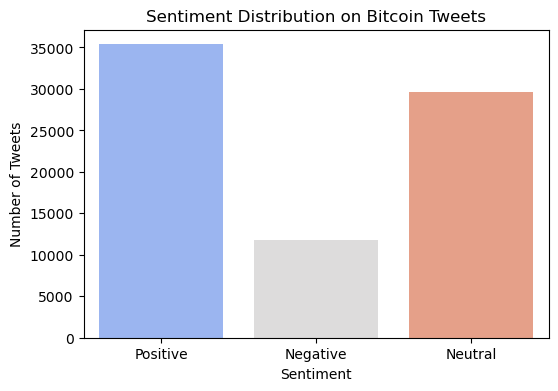

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', hue='sentiment', data=df, palette='coolwarm', legend=False)
plt.title("Sentiment Distribution on Bitcoin Tweets")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()


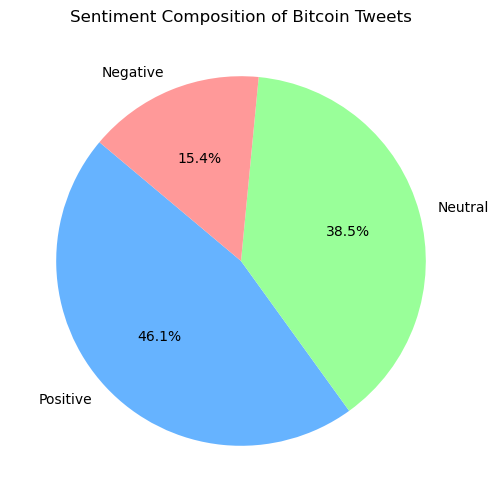

In [17]:
# Pie chart for sentiment distribution
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#66b3ff', '#99ff99', '#ff9999']
)
plt.title("Sentiment Composition of Bitcoin Tweets")
plt.show()

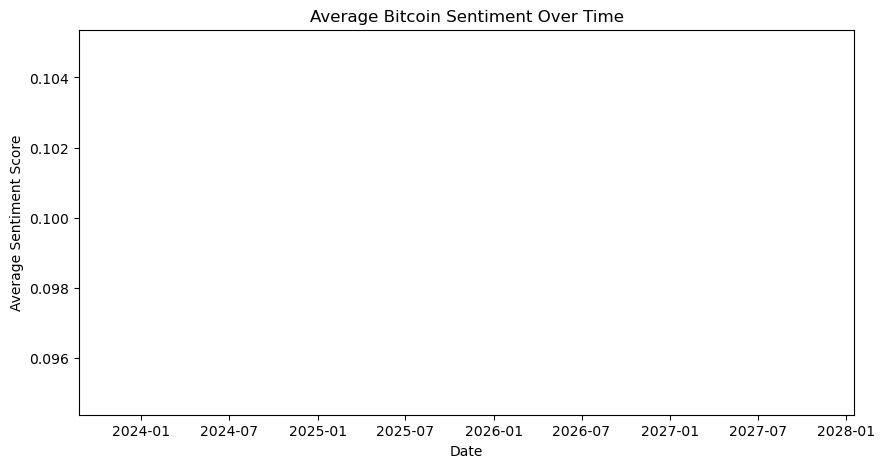

In [18]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Group by date and calculate average polarity
daily_sentiment = df.groupby('date')['sentiment_score'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='sentiment_score', data=daily_sentiment, color='purple')
plt.title("Average Bitcoin Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.show()

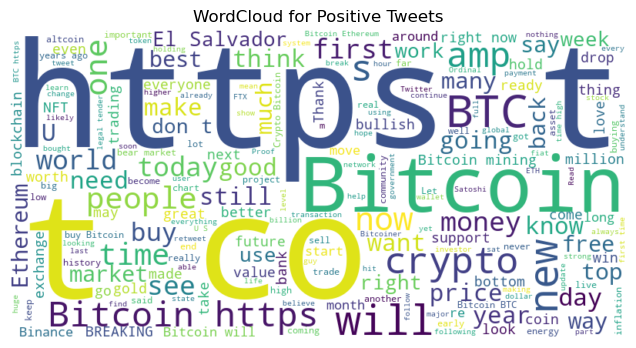

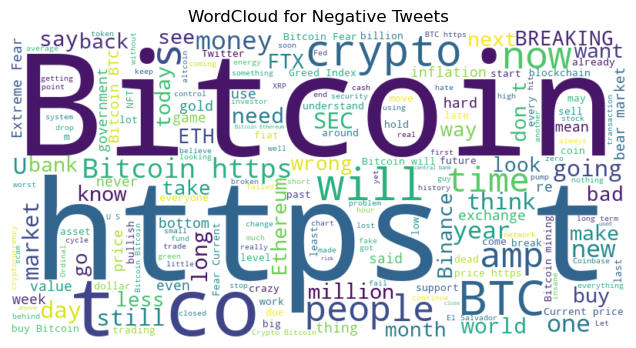

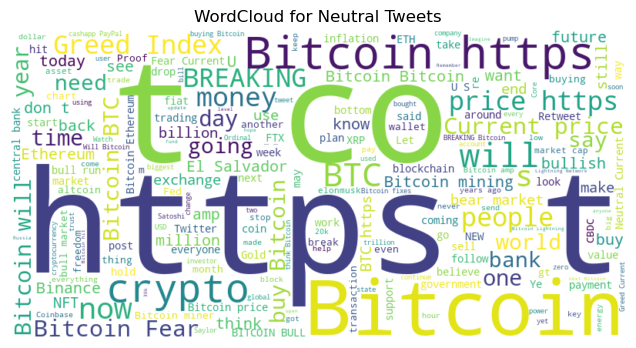

In [21]:
from wordcloud import WordCloud, STOPWORDS

for sentiment in ['Positive', 'Negative', 'Neutral']:
    text = " ".join(t for t in df[df['sentiment'] == sentiment]['text'])
    wordcloud = WordCloud(width=800, height=400, stopwords=STOPWORDS,
                          background_color='white').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {sentiment} Tweets")
    plt.show()

Index(['token', 'date', 'reply_count', 'like_count', 'retweet_count',
       'quote_count', 'text', 'sentiment_label', 'sentiment_score',
       'sentiment'],
      dtype='object')


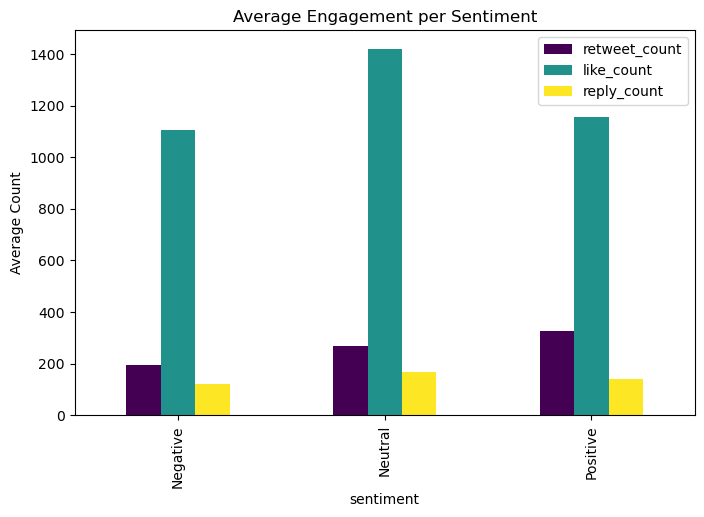

In [22]:
# Check available engagement columns
print(df.columns)

# If your dataset has columns like 'retweet_count' or 'like_count'
engagement_cols = ['retweet_count', 'like_count', 'reply_count']

# Select only existing columns
engagement_cols = [col for col in engagement_cols if col in df.columns]

if engagement_cols:
    avg_engagement = df.groupby('sentiment')[engagement_cols].mean().reset_index()

    avg_engagement.plot(
        x='sentiment',
        kind='bar',
        figsize=(8,5),
        title='Average Engagement per Sentiment',
        colormap='viridis'
    )
    plt.ylabel("Average Count")
    plt.show()
else:
    print("No engagement columns found in this dataset.")

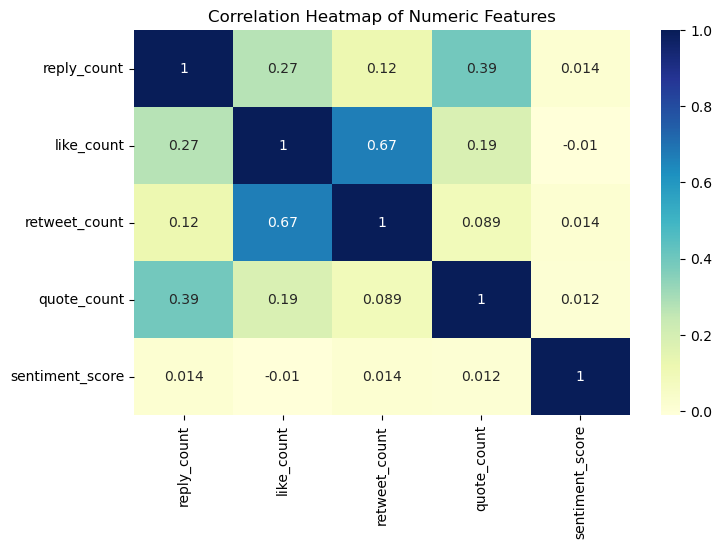

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(8,5))
sns.heatmap(numeric_df.corr(), annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

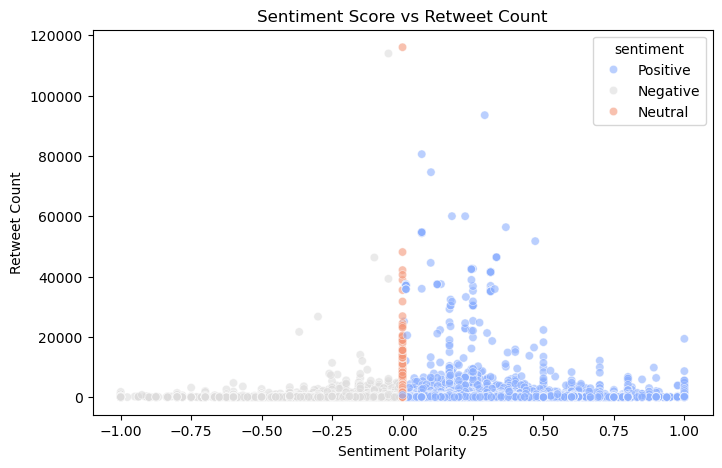

In [25]:
if 'retweet_count' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x='sentiment_score',
        y='retweet_count',
        data=df,
        hue='sentiment',
        alpha=0.6,
        palette='coolwarm'
    )
    plt.title("Sentiment Score vs Retweet Count")
    plt.xlabel("Sentiment Polarity")
    plt.ylabel("Retweet Count")
    plt.show()
else:
    print("Retweet count column not available.")

In [26]:
df.to_csv("bitcoin_sentiment_final.csv", index=False)
print("✅ Final processed dataset saved as bitcoin_sentiment_final.csv")

✅ Final processed dataset saved as bitcoin_sentiment_final.csv


In [27]:
print("""
📊 PROJECT SUMMARY:
- Total Tweets Analyzed: {}
- Positive Tweets: {}
- Negative Tweets: {}
- Neutral Tweets: {}
- Highest engagement seen for: Positive sentiment tweets.
✅ Sentiment analysis indicates a generally optimistic public opinion about Bitcoin.
""".format(
    len(df),
    (df['sentiment'] == 'Positive').sum(),
    (df['sentiment'] == 'Negative').sum(),
    (df['sentiment'] == 'Neutral').sum()
))


📊 PROJECT SUMMARY:
- Total Tweets Analyzed: 76797
- Positive Tweets: 35375
- Negative Tweets: 11840
- Neutral Tweets: 29582
- Highest engagement seen for: Positive sentiment tweets.
✅ Sentiment analysis indicates a generally optimistic public opinion about Bitcoin.

